# **Solution**

---


## **PREPARE Challenge - Phase 3**

# **Summary**

---



### This Notebook Covers:
✅ **Component 0. Setup Environment**: Install dependencies, load SpeachCARE model checkpoints & configure paths

✅ **Component 1.  Model Initialization & Data Preprocessing**: Initializing the SpeachCARE model with the trained checkpoint; preprocessing audio data. To run this step the path to the speaker's audio file and age must be specified if you want to use your own data.

✅ **Component 2. Linguistic Module  (IMPROVED In Phase 3)**: Comprehensive analysis of the speaker's audio transcription using SHAP-values and Linguistic Features. (see Explainability_Linguistic notebook for more details)

✅ **Component 3. Acoustic Module (IMPROVED In Phase 3)**: Comprehensive analysis of the speaker's audio includes Saliency data mapped on the waveform plot, a spectrogram overlaid with SHAP values, pauses, and Fundamental Frequency (F0), as well as the speaker's rhythmic structure and monotonous sections analyzed using Shannon Entropy. Additionally, it includes the analysis of acoustic features such as Shimmer standard deviation, energy in the frequency domain, F0 and F3, with respect to their distribution in the reference dataset. (see Explainability_Acoustic notebook for more details)

✅ **Component 4. Explainability Interface (NEW In Phase 3)**: This is the main interface for the explainability section, which includes the following modules:

- **Patient Health Assessment:** A comprehensive analysis of the patient's Clinical & Functional, Lab Tests, and Social Determinants of Health (SDoH) status.
- **Speech Explainability:** Displays the key findings and results from the linguistic and acoustic modules that are directly related to cognitive impairment.

The interface also offers an overview of the model's output, providing four key findings for each of the Acoustic, Linguistic, Clinical & Functional, and SDoH sections, displayed at the top.



# **Hardware**

---

**Hardware Requirements**
*  Components 1–4: A minimum of one NVIDIA T4 GPU with 16 GB of VRAM is required.


**Training Time**
*  No training is needed; you only need to load the model checkpoint.

**Inference Time**
*  Components 1–4: Inference time is estimated to be less than 5 minutes for each component.


# **Component 0. Setup Environment**

---




**Install the required python packages**

This cell installs all Python packages listed in `requirements.txt`. The file contains all necessary dependencies.

- Run this cell only once at the beginning of your session

- If you encounter errors, you may need to restart the runtime after installation


In [ ]:
!git clone https://github.com/SpeechCARE/SpeechCARE_Explainability_Framework.git

In [1]:
import sys
sys.path.append('/SpeechCARE_Explainability_Framework')

In [ ]:
%cd SpeechCARE_Explainability_Framework

In [ ]:
!pip install --upgrade pip
!pip uninstall xformers -y
!pip install -r requirements.txt
!apt update && apt install ffmpeg -y

**Import Necessary Libraries**

This cell imports all required Python libraries and modules. The imports are organized by functionality for better understanding.

In [ ]:
# Standard library imports
import os
import warnings

# Third-party imports
import pandas as pd
import torch
import yaml
from IPython.display import HTML, Image, Markdown, display

# Custom module imports
# --- Model Management ---
from model.ModelWrapper import ModelWrapper
from model.WeightsManager import WeightManager

# --- Data Processing ---
from utils.Config import Config
from utils.Utils import free_gpu_memory, load_yaml_file
from utils.dataset_utils import peak_normalization, preprocess_data

# --- Linguistic Analysis ---
from linguistic_module.text_feature_extraction import TextFeatureExtractor
from linguistic_module.text_interpreter import TextInterpreter
from explainability.SHAP.LinguisticShap import LinguisticShap

# --- Acoustic Analysis ---
from acoustic_module.FeatureExtraction import analyze_column_single, get_audio_files
from acoustic_module.EntropyAnalyzer import EntropyAnalyzer
from acoustic_module.utils import detect_pauses_from_audio
from acoustic_module.interpretation_report import (
    generate_vocal_analysis_report,
    vocal_analysis_interpretation_report
)

# --- Explainability ---
from explainability.Gradient_based.saliency_map import compute_saliency_waveform
from explainability.SHAP.AcousticShap import AcousticShap
from explainability.plotting.explainability_plotting import (
    plot_SHAP_highlighted_spectrogram,
    plot_colored_waveform,
    plot_entropy
)

# --- Interface ---
from interface.generate_interface import generate_interface

# Configuration
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

**OpenRouter API Configuration**

Configure the OpenRouter API connection settings for making requests.

**Configuration Options:**

* `api_key`: Replace 'YOUR_API_KEY' with your actual OpenRouter API key

* `base_url`: The OpenRouter API endpoint (typically doesn't need modification)

In [ ]:
openrouter_base_url = 'https://openrouter.ai/api/v1'
open_ai = {'api_key': 'YOUR_API_KEY', 'base_url':openrouter_base_url}

**Download Model Checkpoint**

Downloade-trained modecheckpointts from Google Drive using the WeightManager class.


**Configuration Options:**

- `file_id`: Replace with your own Google Drive file ID

- `output_name`: Change to save weights with a different filename

In [5]:
weight_path = "model_weights/model.pt"

In [ ]:
# Initialize the weight manager
weight_manager = WeightManager()

try:
    # Download model checkpoint from Google Drive
    weight_path = weight_manager.download_weights(
        file_id="1-SLBGZRoNGRPHBtWJUDR8WCFpFiVYJM4",  # Google Drive file ID
        output_name="model.pt",                       # Name for downloaded file
    )
    print(f"Success: Weights saved to {weight_path}")

except Exception as e:
    print(f"Error downloading weights: {e}")
    print("Please check:")
    print("- Your internet connection")
    print("- The file ID is correct")
    print("- Google Drive permissions")

**Load and Display Configurations**

Loads and displays configuration file that control model behavior.

In [6]:
# Display model configuration
display(Markdown("### Model Configuration"))
with open("data/model_config.yaml") as f:
    model_config = yaml.safe_load(f)
    display(model_config)

# Display pause detection configuration
display(Markdown("### Pause Detection Configuration"))
with open("data/pause_config.yaml") as f:
    pause_config = yaml.safe_load(f)
    display(pause_config)

# Initialize config objects for the application
config = Config(load_yaml_file("data/model_config.yaml"))
config_pause = Config(load_yaml_file("data/pause_config.yaml"))

### Model Configuration

{'model_checkpoints': {'HUBERT': 'facebook/hubert-base-ls960',
  'WAV2VEC2': 'facebook/wav2vec2-base-960h',
  'mHuBERT': 'utter-project/mHuBERT-147',
  'MGTEBASE': 'Alibaba-NLP/gte-multilingual-base',
  'WHISPER': 'openai/whisper-large-v3-turbo'},
 'config': {'seed': 133,
  'bs': 4,
  'epochs': 14,
  'lr': '1e-6',
  'hidden_size': 128,
  'wd': '1e-3',
  'integration': 16,
  'num_labels': 3,
  'txt_transformer_chp': 'Alibaba-NLP/gte-multilingual-base',
  'speech_transformer_chp': 'utter-project/mHuBERT-147',
  'segment_size': 5,
  'active_layers': 12,
  'demography': 'age_bin',
  'demography_hidden_size': 128,
  'max_num_segments': 7}}

### Pause Detection Configuration

{'config': {'device': 'cpu',
  'batch_size': 16,
  'compute_type': 'int8',
  'model_id': 'large-v3'}}

# **Component 1. Model Initialization & Data Preprocessing**
---

### **Model Intialization:**
The SpeechCARE model with trained checkpoint is loaded here.


**Key Components:**

- `ModelWrapper`: Handles model architecture

- `config`: Contains model parameters

- `weight_path`: Location of trained SpeechCARE model checkpoint

In [ ]:
# Initialize model wrapper with configuration
wrapper = ModelWrapper(config)

# Load trained weights into the model
model = wrapper.get_model(weight_path)
model.eval()

print("Model successfully initialized with weights from:", weight_path)

### **Data Preprocessing:**

Prepares a specific audio sample by denoising the audio, providing its transcription and age category. You should provide:

- `AUDIO_PATH`: Full path to the audio file, WAV format recommended (required for an individual sample) .
- `AGE`: Age of the speaker as an integer value (required for an individual sample).

In [8]:
AUDIO_PATH = f"data/qnvo.mp3"  # Path to the input audio file (update it with your desired audio file path)
AGE = 72  # Age of the speaker
ID = "qnvo"

In [ ]:
# Process audio sample and corresponding age
# Arguments:
#   audio_path: Path to input audio file
#   age: Speaker's age
#   output_dir: Directory to store processed audio file

processed_audio_path, demography_info, transcription = preprocess_data(audio_path=AUDIO_PATH, age=AGE,apply_lowpass = True, output_dir='../processed_audio')
peak_norm_audio_path = peak_normalization(audio_path=AUDIO_PATH)

# Convert age (by default: int) to tensor
# Reshaped it to (1, 1) for batch processing compatibility
demography_tensor = torch.tensor(demography_info, dtype=torch.float16).reshape(1, 1)

# --- Word-Level Analysis Setup ---
# Print analysis information for verification
print(f"Analyzing sample: {processed_audio_path}")
print(f"Speaker age category: {demography_info}")


# **Component 2. Linguistic Module (IMPROVED In Phase 3)**


---




### **Initiallization**

In [10]:
linguistc_explainer = LinguisticShap(model)
print("Linguistic explainer ready for analysis")

Linguistic explainer ready for analysis


In [11]:
# Run inference to get predicted_label and transcription
predicted_label, probabilities = model.inference(config=config,audio_path = processed_audio_path, demography_info=AGE)
print("Running inference to compute predicted_label and transcription.")

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the
Tokenizing transcription...
Preprocessing audio...
Running inference...
Running inference to compute predicted_label and transcription.


### **Step 1. SHAP Values Generation**




In [17]:
shap_values, shap_html_result = linguistc_explainer.get_text_shap_results()

Running SHAP values...
Input text: [" from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the"]
Values explained...
In len 2
mci


### **Step 2. Linguistic Feature Extraction (NEW in Phase3)**




In [ ]:
extractor = TextFeatureExtractor()
features = extractor.extract_all_features(text = model.transcription, audio_path= 'data/qnvo.mp3',save_path = "")

### **Step 3. LLM (LLAMA 70b) Interpretation (IMPROVED in Phase3)**




In [18]:
interpreter = TextInterpreter(openai_config = open_ai) #initalizing the interpretor class
result_linguistic = interpreter.get_all_interpretations(model.transcription,predicted_label, shap_values, features, probabilities)

# **Component 3. Acoustic Module (IMPROVED In Phase 3)**


---




### **Step 1: Calculating Saliency Mapping (NEW In Phase 3)**


In [ ]:
# Generating the input_values for the model from the audio
input_values,_,_,_ = model.preprocess_data(peak_norm_audio_path,segment_length=model.config.segment_size,demography_info=demography_info)

In [20]:
# Computing Saliency Data
saliency_data = compute_saliency_waveform(model=model,input_segments=input_values,audio_path=peak_norm_audio_path,segment_length=model.config.segment_size)

In [21]:
# Generate the plot of raw waveform with mapped saliency
colored_waveform = plot_colored_waveform(
      saliency_data=saliency_data,
      total_duration = saliency_data['time'][-1],
      figsize = (20, 3),
      return_base64=True #if False, None will be returned
      )

### **Step 2: Spectrogram & Acoustic Feature Analysis (IMPROVED In Phase 3)**

In [22]:
# Initalize the acoustic explainer class
acoustic_explainer = AcousticShap(model)
print("Acoustic explainer ready for analysis")

Acoustic explainer ready for analysis


In [ ]:
# Extract Informative pauses
pauses = detect_pauses_from_audio(config=config_pause,
        audio_path=processed_audio_path,
        sr=48000,
        energy_threshold=0.001,#Lower values detect more subtle pauses
        min_pause_duration=0.1, #Adjust to ignore very short pauses
        expansion_threshold=0.03, #Boundary expansion threshold for refining pauses
        marked=True,  # Mark important pauses
        refined=True  # Use refined boundaries

    )

In [ ]:
# Generating the spectrogram of the audio file plot with SHAP values, Fundamental Frequency and pauses overlayed on
SHAP_highlighted_spectrogram = acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    spectrogram_type='shap',
    pauses=pauses,  # Pass detected pauses
    formants_to_plot=["F0"],  #Options: Formant Frequencies (F1, F2, F3, ...)
    plot=True,
    figsize=(20,4),
    return_base64=True #if False, None will be returned
)

### **Step 3: Calculating of the Speaker's Rhythmic Structure by Shannon Entropy (IMPROVED In Phase 3)**


In [26]:
entropy_analyzer = EntropyAnalyzer() #Initializing the Entropy Analyser class

entropy_data = entropy_analyzer.analyze(
    processed_audio_path,
    window_size=15, #Analysis window length
    min_duration=5, #Minimum valid segment duration
    segments_merge_gap=.1, #Max gap between segments to merge
    segments_std_threshold=0.075, #Entropy fluctuation threshold
    flucturation_frame_size=17, #Local dynamic change resolution
    visualize=False,
    figsize=(20,2),
    return_base64=True #if False, None will be returned
    )

### **Step 4: Acoustic Feature Analysis with Quartile Categorization**



In [27]:
# Load key acoustic features from CSV of the reference dataset
REFERENCE_DATASET_DIR = None # Leave this unchange if you don't have a custom dataset, otherwise, put the path to your audio data folder
if REFERENCE_DATASET_DIR:
    data_df = get_audio_files(REFERENCE_DATASET_DIR , 1168)
else:
    data_df = pd.read_csv("data/vocal_features.csv")

In [28]:
# Analyze and categorize Shimmer standard deviation of an individual audio sample
# Compares against reference distribution in data_df
shimmer_info = analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'shimmer_std'                 # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'shimmer_std' were calculated based on this reference distribution.

Analysis Results for qnvo:
- shimmer_std value: 0.7331
- Quartile category: Q3: Almost Unstable

Full Quartile Ranges:
  Q1: Stable          : 0.3054 to 0.5041
  Q2: Almost Stable   : 0.5041 to 0.7028
  Q3: Almost Unstable : 0.7028 to 0.9015
  Q4: Unstable        : 0.9015 to 1.1002


In [30]:
# Analyze and categorize energy of frequency domain
# Compares against reference distribution in data_df
energy_info = analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'energy_frequency_domain'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'energy_frequency_domain' were calculated based on this reference distribution.

Analysis Results for qnvo:
- energy_frequency_domain value: 96.9050
- Quartile category: Q4: High

Full Quartile Ranges:
  Q1: Very Low        : 49.3604 to 64.2618
  Q2: Low             : 64.2618 to 79.1631
  Q3: Moderate        : 79.1631 to 94.0644
  Q4: High            : 94.0644 to 108.9657


In [31]:
# Analyze and categorize F0 standard deviation distribution
# Compares against reference distribution in data_df
fundamental_frequency_info = analyze_column_single(
    data_df,                   # Reference feature dataset
    AUDIO_PATH,                # Individual audio sample path
    'fundamental_frequency'    # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'fundamental_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- fundamental_frequency value: 0.2414
- Quartile category: Q2: Slightly Flat

Full Quartile Ranges:
  Q1: Very Flat       : 0.0317 to 0.1586
  Q2: Slightly Flat   : 0.1586 to 0.2855
  Q3: Natural         : 0.2855 to 0.4124
  Q4: Dynamic         : 0.4124 to 0.5393


In [32]:
# Analyze and categorize F3 standard deviation distribution
# Compares against reference distribution in data_df
formant_frequency_info = analyze_column_single(
    data_df,                # Reference feature dataset
    AUDIO_PATH,             # Individual audio sample path
    'formant_frequency'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'formant_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- formant_frequency value: 0.0992
- Quartile category: Q2: Limited Coordination

Full Quartile Ranges:
  Q1: Very Limited Coordination: 0.0407 to 0.0828
  Q2: Limited Coordination: 0.0828 to 0.1249
  Q3: Normal Coordination: 0.1249 to 0.1670
  Q4: High Coordination: 0.1670 to 0.2091


### **Step 5. Prepare Acoustic Interpretation**

In [33]:
# The report consolidates various vocal features extracted from the audio sample
features_index, report = generate_vocal_analysis_report(
    # Extract the sample name from the audio file path (removes path and extension)
    sample_name=ID,
    # Fundamental frequency (F0) values - indicates pitch characteristics
    f0_analysis=fundamental_frequency_info,
    # F3 formant values - relates to vocal tract resonance (often associated with brightness/ring)
    f3_analysis=formant_frequency_info,
    # Count of detected pauses in speech/audio
    pause_count=len(pauses),
    # Segments where pitch remains flat (may indicate monotony)
    flat_segments=entropy_data['flat_segments'],
    # Shimmer value (amplitude variation between cycles)
    shimmer_analysis=shimmer_info,
    # Energy/volume metrics and their perceptual category
    energy_analysis=energy_info
)

In [34]:
# Generate the final interpretation as a coherent text
acoustic_interpretation , _ = vocal_analysis_interpretation_report(os.path.basename(AUDIO_PATH),features_index,model.predicted_label)

# **Component 4. Explainability Interface (NEW In Phase 3)**


---





### **Patients' Information  Dataset**

> The Patients' Information Dataset contains data collected from sample patients, categorized into six key areas: Demographic and Basic Information, Social Determinants of Health (SDoH), Psychological and Behavioral, Functional Status, Cognitive Symptoms, and Physiological and Medical Interventions. The dataset is stored in data/patients_information.csv. These categories were defined in consultation with clinicians and experts to ensure they directly relate to cognitive impairment. Each category also includes thresholds for values that indicate an immediate threat related to cognitive impairment. This dataset will be used in the "Patient Health Assessment" module within the explainability interface. In this module, items identified as an immediate threat in each category are selected and reported as part of the RAG method used for generating interpretations.


In [35]:
# Generate the patient interface HTML by compiling all relevant data components
interface_html = generate_interface(
    # Path to the Excel file containing patient information
    excel_path="data/patients_information.xlsx",

    # Unique identifier for the patient
    patient_id=ID,

    # Path to the patient's profile image (JPEG format)
    profile_image_path=f'data/{ID}.jpeg',

    # Path to the patient's audio recording
    audio_path=AUDIO_PATH,

    # Model prediction information including:
    # - predicted_status: The predicted clinical status (converted from label)
    # - confidence: Prediction confidence score (rounded to 2 decimal places)
    # - contribution: Model's gate weights showing each module contributions
    model_info={
        "predicted_status": model.label_rev_map[predicted_label],
        "confidence": round(probabilities[predicted_label], 2),
        "contribution": model.last_gate_weights[0]
    },

    # Configuration for OpenAI API calls
    openai_config=open_ai,

    # Linguistic interpretation results generated in "Linguistc Module"
    linguistic_interpretation=result_linguistic[-1],

    # HTML-formatted transcription with SHAP explanation highlights
    transcription= shap_html_result,

    # Acoustic visualization data including:
    # - colored_waveform: Waveform with saliency mapping
    # - entropy: Waveform with highlighted monotonous sections determining using Shannon Entropy analysis
    # - SHAP_highlighted_spectrogram: Spectrogram with important features, including SHAP-values, pauese, and F0, highlighted
    acoustic_plots={
        "colored_waveform": colored_waveform,
        "entropy": entropy_data['base64_image'],
        "SHAP_highlighted_spectrogram": SHAP_highlighted_spectrogram
    },

    # Interpretation of acoustic features and their clinical significance
    acoustic_interpretation=acoustic_interpretation
)


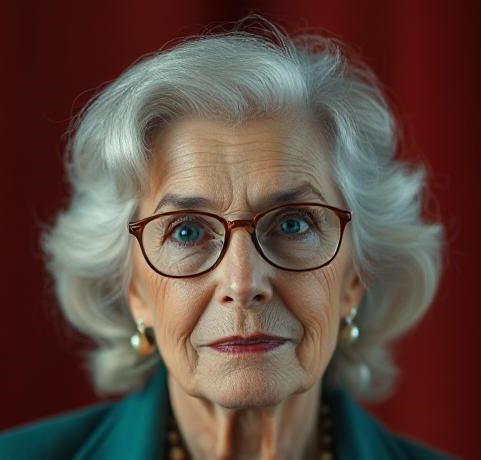
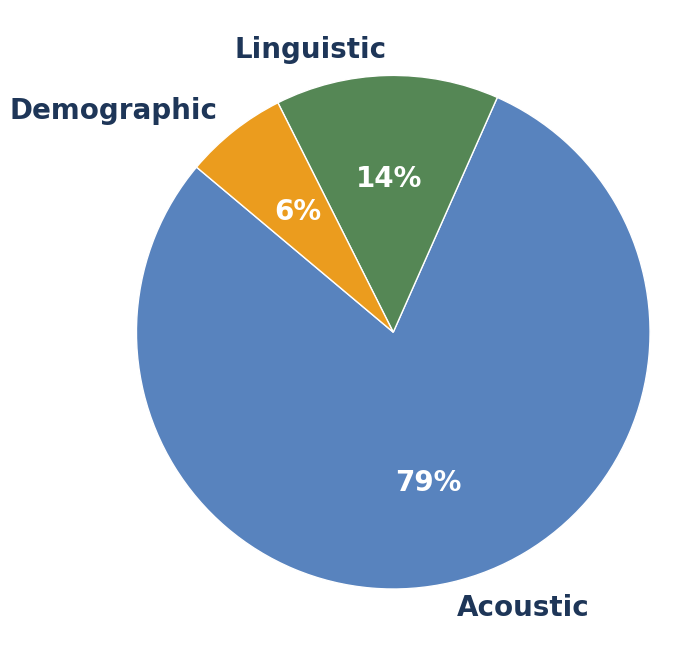
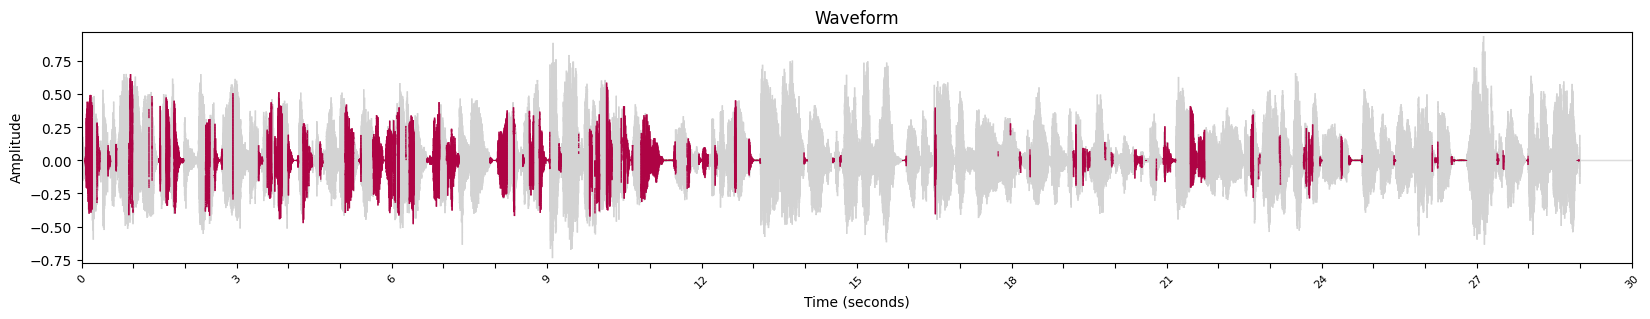
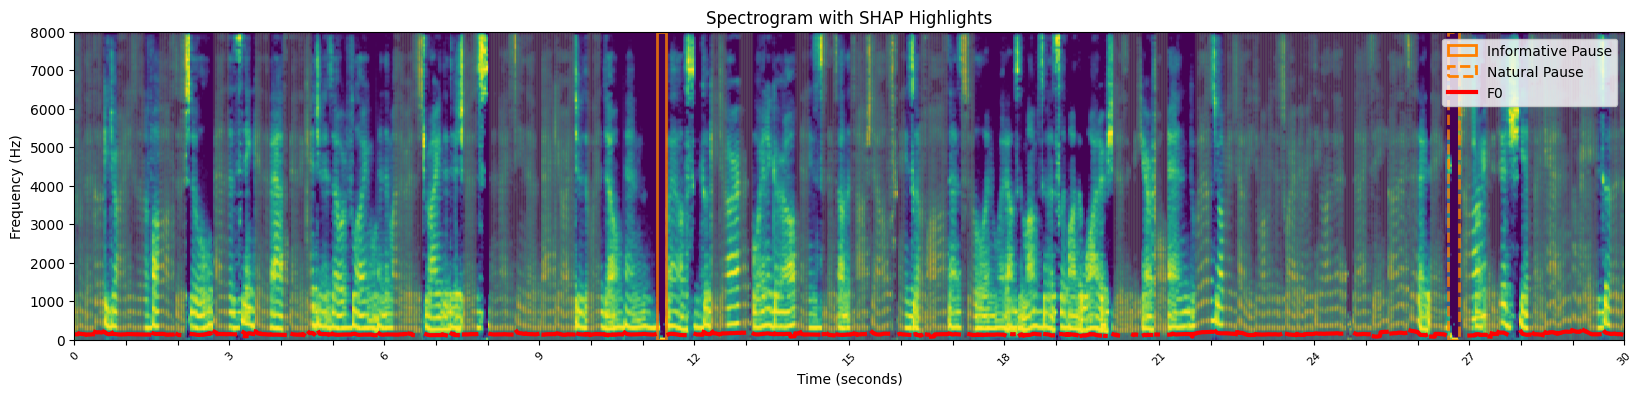
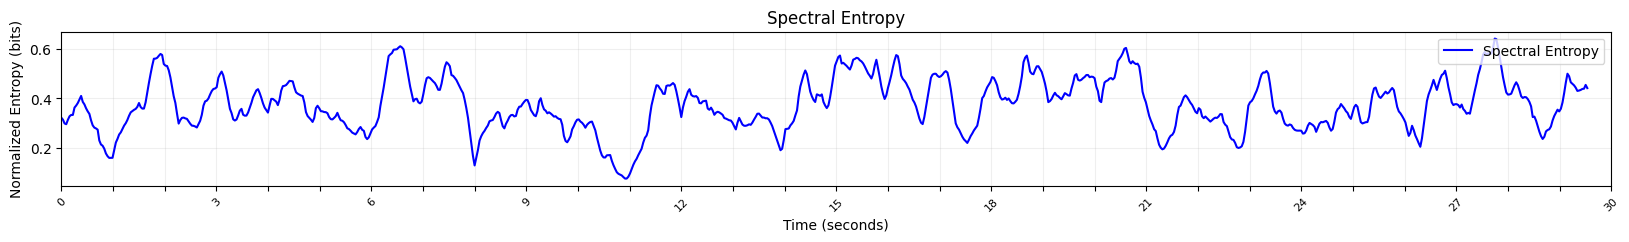
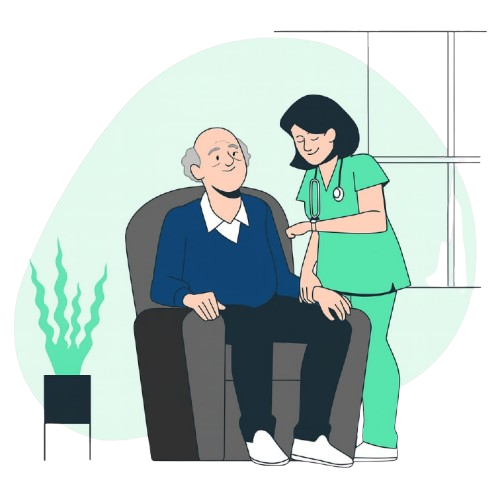

In [36]:
# Visualizing the interface
HTML(interface_html)